# MOF Spacy prediction
## Objective

The purpose of this notebook is to predict the top 3 **mode of failure** base on **Consequence** description. This is for developer to debug the prediction steps


In [770]:
import spacy
import pandas as pd
from ipyfilechooser import FileChooser
import re
from pathlib import Path
from spacy.tokens import DocBin
import spacy
import itertools
from collections import OrderedDict
import numpy as np

In [771]:
model_name = "textcat_multilabel"
model_list = [name for name in os.listdir(str(Path().resolve().parents[0])+'/'+model_name+'/models')]
# model = "model-v.2phase-0-cause-consequence-prediction" 
# model = "model-v.1-phase-0-consequence-prediction" 
# model = "model-v.1-phase-1-consequence-prediction" 
model = "model-v.1-phase-1-cause-consequence-prediction" 
# model = "model-v.1-phase-1-consequence-prediction-nowcs" 
# model = "model-v.1-phase-1-cause-consequence-prediction-nowcs" 

In [772]:
# Load latest model
nlp = spacy.load(str(Path().resolve().parents[0])+'/textcat_multilabel/models/'+model+'/training/model-best')

In [773]:
# df = pd.read_csv("../data/phase_0_processed_data.csv")
# df = df[df['type'] == "test"]

df = pd.read_csv("../data/phase_1_processed_data.csv")
df = df[df['type'] == "test"]
# df = pd.read_csv("../data/test.csv")

# df = pd.read_csv("../data/phase_1_processed_data.csv")
# df = df[(df['type'] == "test") & (df['wcs1'] != "No WCS")]
# df = pd.read_csv("../data/test_nowcs.csv")

consequence_column_name = "cause_conseq"
# consequence_column_name = "Consequence"

In [774]:
df.head()

,Unnamed: 0,Center,ProjectId,Project Name,Company Name,Cause,Consequence,UnwantEvent_wo_Receptor,wcs1,cause_conseq,...,etag_annotated,name_annotated,eqps,cause_conseq_reduced,UnwantEvent_wo_Receptor_original,wcs1_original,ue_phase0,wcs_phase0,orig+phase0_label_UE,orig+phase0_label_WCS
17070,0,P-555/P-571 Alkylate Fractionator Bottom Pump - Damage - Fire/Explosion,1065,2018 Billings Refinery Unit 43 HF Alkylation,Phillips 66,43FCV571 at Alkylate Fractionator W-82 inlet malfunctions closed or Manual valve closed on fractionator inlet,"Loss of feed to Alkylate Fractionator W-82, potential deadhead of Alkylate Fractionator Bottoms Pump P-555 or P-571 as level control attempts to maintain level in tower, potential damage to pump and/or pump seal, potential seal leak, potential loss of containment of heavy alkylate with trace amounts of HF acid/fluorides, potential personnel exposure, potential fire, potential impact to personnel health and safety",Damage,Fire/Explosion,"43FCV571 at Alkylate Fractionator W-82 inlet malfunctions closed or Manual valve closed on fractionator inletLoss of feed to Alkylate Fractionator W-82, potential deadhead of Alkylate Fractionator Bottoms Pump P-555 or P-571 as level control attempts to maintain level in tower, potential damage to pump and/or pump seal, potential seal leak, potential loss of containment of heavy alkylate with trace amounts of HF acid/fluorides, potential personnel exposure, potential fire, potential impact to personnel health and safety",...,[],[],"['43FCV571', 'W-82', 'inletLoss', 'W-82', 'P-555', 'P-571']","at Alkylate Fractionator inlet malfunctions closed or Manual valve closed on fractionator of feed to Alkylate Fractionator , potential deadhead of Alkylate Fractionator Bottoms Pump or as level control attempts to maintain level in tower, potential damage to pump and/or pump seal, potential seal leak, potential loss of containment of heavy alkylate with trace amounts of HF acid/fluorides, potential personnel exposure, potential fire, potential impact to personnel health and safety",Damage,Fire/Explosion,Damage,Fire/Explosion,Damage!#Damage,Fire/Explosion!#Fire/Explosion
17071,1,Downstream LPG Users - Leak - Loss of Containment,1065,2018 Billings Refinery Unit 43 HF Alkylation,Phillips 66,Loss of cooling water supply to First Stage Alkylation Reactor X-4304,"Loss of cooling at First Stage Alkylation Reactor X-4304 leading to increased ASO-make and potential for increased acid consumption, increased potential for acid runaway, if runaway conditions are not mitigated the potential for development of pin-hole leaks of LPG in equipment downstream of Defluorinators/KOH Treaters may occur over time, potential personnel exposure, potential fire or explosion, potential impact to personnel health and safety",Damage,Loss of Containment,"Loss of cooling water supply to First Stage Alkylation Reactor X-4304Loss of cooling at First Stage Alkylation Reactor X-4304 leading to increased ASO-make and potential for increased acid consumption, increased potential for acid runaway, if runaway conditions are not mitigated the potential for development of pin-hole leaks of LPG in equipment downstream of Defluorinators/KOH Treaters may occur over time, potential personnel exposure, potential fire or explosion, potential impact to personnel health and safety",...,[],[],['X-4304'],"Loss of cooling water supply to First Stage Alkylation Reactor Loss of cooling at First Stage Alkylation Reactor leading to increased ASO-make and potential for increased acid consumption, increased potential for acid runaway, if runaway conditions are not mitigated the potential for development of pin-hole leaks of LPG in equipment downstream of Defluorinators/KOH Treaters may occur over time, potential personnel exposure, potential fire or explosion, potential impact to personnel health and safety",Leak,Loss of Containment,Leak/Rupture,Loss of Containment,Leak!#Leak/Rupture,Loss of Containment!#Loss of Containment
17072,2,4

In [775]:
df.shape

(2455, 22)

In [776]:
# Phase 0 labels
# UE_list = ['Leak/Rupture', 'Damage', 'Liquid Carryover', 'Upset',
#        'Contamination', 'Overpressure', 'Increased Flow',
#        'Inefficient Operation', 'Overheat', 'Overflow', 'High Pressure',
#        'Loss of Flow', 'Flame Out/Instability', 'Increased Emissions',
#        'Seal Leak', 'Corrosion/Erosion', 'Gas Blowby', 'High Temperature',
#        'Shutdown/Trip', 'Failure', 'Freezing',
#        'Maintenance/Sampling/Operator Error', 'Explosive Mixture',
#        'Misdirected Flow', 'Vacuum', 'Runaway/Unstable Reaction',
#        'Plugging', 'Fouling', 'Low Pressure', 'Surging',
#        'Loss of Power/Signal/Analyzer', 'Coking', 'Valve/Vent Failure',
#        'Cavitation', 'Chemical Degradation', 'Loss of Instrument Air',
#        'Low Temperature', 'Flammable Atmosphere', 'Water/Steam Hammer ',
#        'Embrittlement', 'Low Level', 'Hydrate Formation',
#        'Vapour Cloud Formation', 'Deadhead', 'Accumulation',
#        'Increased Cracking', 'Flooding', 'High Level']
# WCS_list = ['Fire/Explosion', 'No WCS', 'Loss of Production',
#        'Loss of Containment', 'Off-Spec Product', 'Shutdown',
#        'Increased Emissions', 'Inefficient Operation', 'Contamination',
#        'Leak/Rupture', 'Early Replacement', 'Economic Impact',
#        'Ship List', 'Personnel Exposure/Injury', 'Process Upset',
#        'Delayed Startup', 'Increased Maintenance',
#        'Downstream User Impact']
# Overlap_list = [i for i in WCS_list if i in UE_list]
# print(len(UE_list))
# print(len(WCS_list))
# print(Overlap_list)

In [777]:
#Phase 1 labels
UE_list = ['Damage', 'Upset', 'Release', 'Shutdown/Trip', 'Flame Instability',
       'Increased Emissions', 'Maintenance/Sampling/Operator Error',
       'Explosive Mixture', 'Loss of Power/Signal/Analyzer']
WCS_list = ['Fire/Explosion', 'No WCS', 'Loss of Production',
       'Loss of Containment', 'Off-Spec Product', 'Process Upset',
       'Early Replacement/Increased Maintenance',
       'Personnel Exposure/Injury']
Overlap_list = [i for i in WCS_list if i in UE_list]
print(len(UE_list))
print(len(WCS_list))
print(Overlap_list)

9
8
[]


In [779]:
texts = df[consequence_column_name].tolist()
docs = list(nlp.pipe(texts))
UE = list()
WCS = list()
a = 0
for doc in docs:
    a+=1
    temp_list = list({k: v for k, v in sorted(doc.cats.items(), key=lambda item: item[1],reverse= True)}.items())
    UE_state = False
    WCS_state = False
    for i in temp_list:
        if UE_state and WCS_state:
            break
        elif any(item in [temp_list[0][0],temp_list[1][0]] for item in  Overlap_list):
            UE.append(i[0])
            WCS.append(i[0])
            UE_state = True
            WCS_state = True
            continue
        elif i[0] in UE_list and not UE_state:
            UE.append(i[0])
            UE_state = True
            continue
        elif i[0] in WCS_list and not WCS_state:
            WCS.append(i[0])
            WCS_state = True
            continue

df['UE_pred'] = UE
df['WCS_pred'] = WCS

In [780]:
df_result = df.copy()

In [781]:
from sklearn.metrics import classification_report

In [782]:
print(classification_report(df_result['UnwantEvent_wo_Receptor'],df_result['UE_pred']))

                                     precision    recall  f1-score   support

                             Damage       0.88      0.98      0.93      1893
                  Explosive Mixture       0.10      0.05      0.07        38
                  Flame Instability       0.73      0.15      0.25        52
                Increased Emissions       0.73      0.65      0.69       211
Maintenance/Sampling/Operator Error       0.00      0.00      0.00        26
                            Release       0.72      0.54      0.62        61
                      Shutdown/Trip       0.00      0.00      0.00         0
                              Upset       0.42      0.20      0.27       174

                           accuracy                           0.84      2455
                          macro avg       0.45      0.32      0.35      2455
                       weighted avg       0.81      0.84      0.81      2455



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [783]:
print(classification_report(df_result['wcs1'],df_result['WCS_pred']))

                                         precision    recall  f1-score   support

Early Replacement/Increased Maintenance       0.00      0.00      0.00         0
                         Fire/Explosion       0.84      0.71      0.77       598
                    Loss of Containment       0.75      0.87      0.81      1380
                     Loss of Production       1.00      0.04      0.07        27
                                 No WCS       0.63      0.59      0.61       268
                       Off-Spec Product       0.00      0.00      0.00         2
              Personnel Exposure/Injury       0.32      0.20      0.25       142
                          Process Upset       0.00      0.00      0.00        38

                               accuracy                           0.74      2455
                              macro avg       0.44      0.30      0.31      2455
                           weighted avg       0.73      0.74      0.72      2455



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [784]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot:>

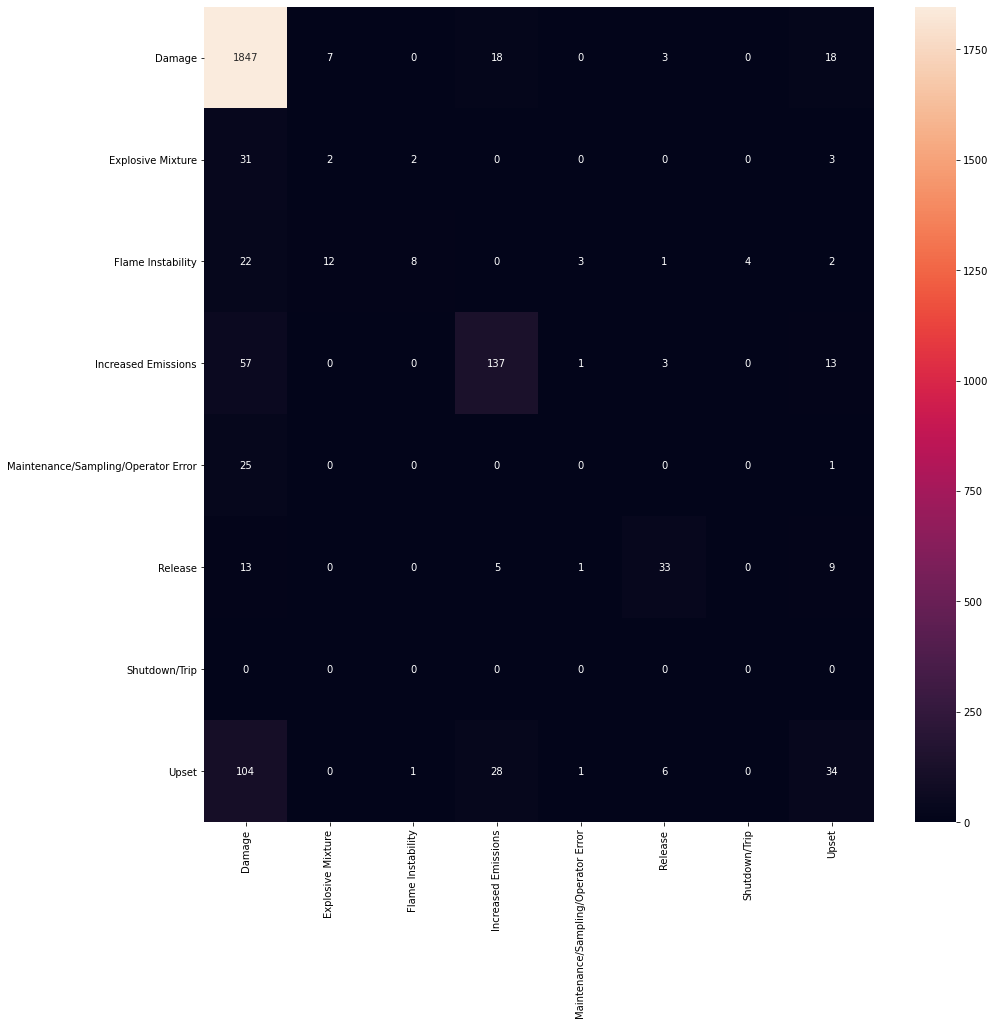

In [785]:
labels_UE = unique_labels(df_result['UnwantEvent_wo_Receptor'],df_result['UE_pred'])
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(confusion_matrix(df_result['UnwantEvent_wo_Receptor'],df_result['UE_pred']), annot= True,fmt='g', ax = ax,xticklabels=labels_UE, yticklabels=labels_UE)

/tmp/ipykernel_5591/4124809709.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<AxesSubplot:>

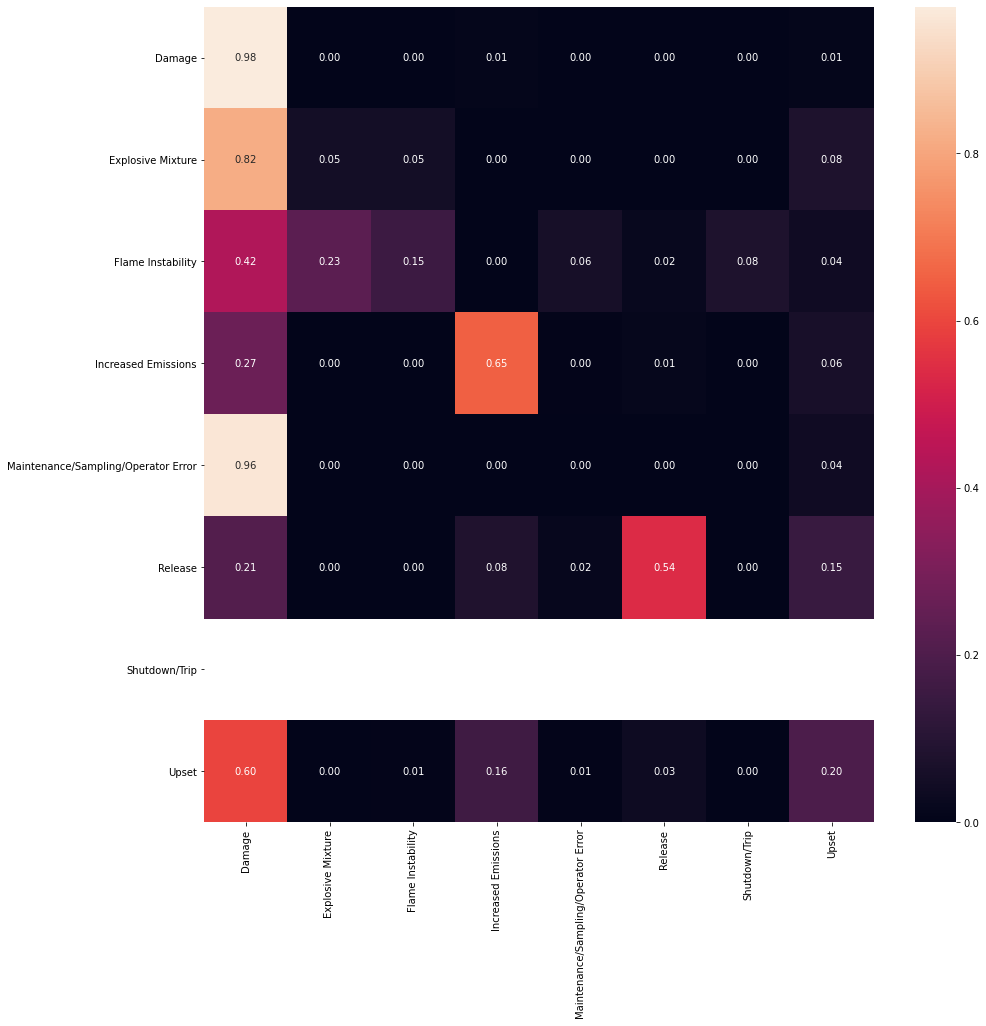

In [786]:
fig, ax = plt.subplots(figsize=(15,15)) 
cm = confusion_matrix(df_result['UnwantEvent_wo_Receptor'],df_result['UE_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot= True,fmt='.2f', ax = ax,xticklabels=labels_UE, yticklabels=labels_UE)

<AxesSubplot:>

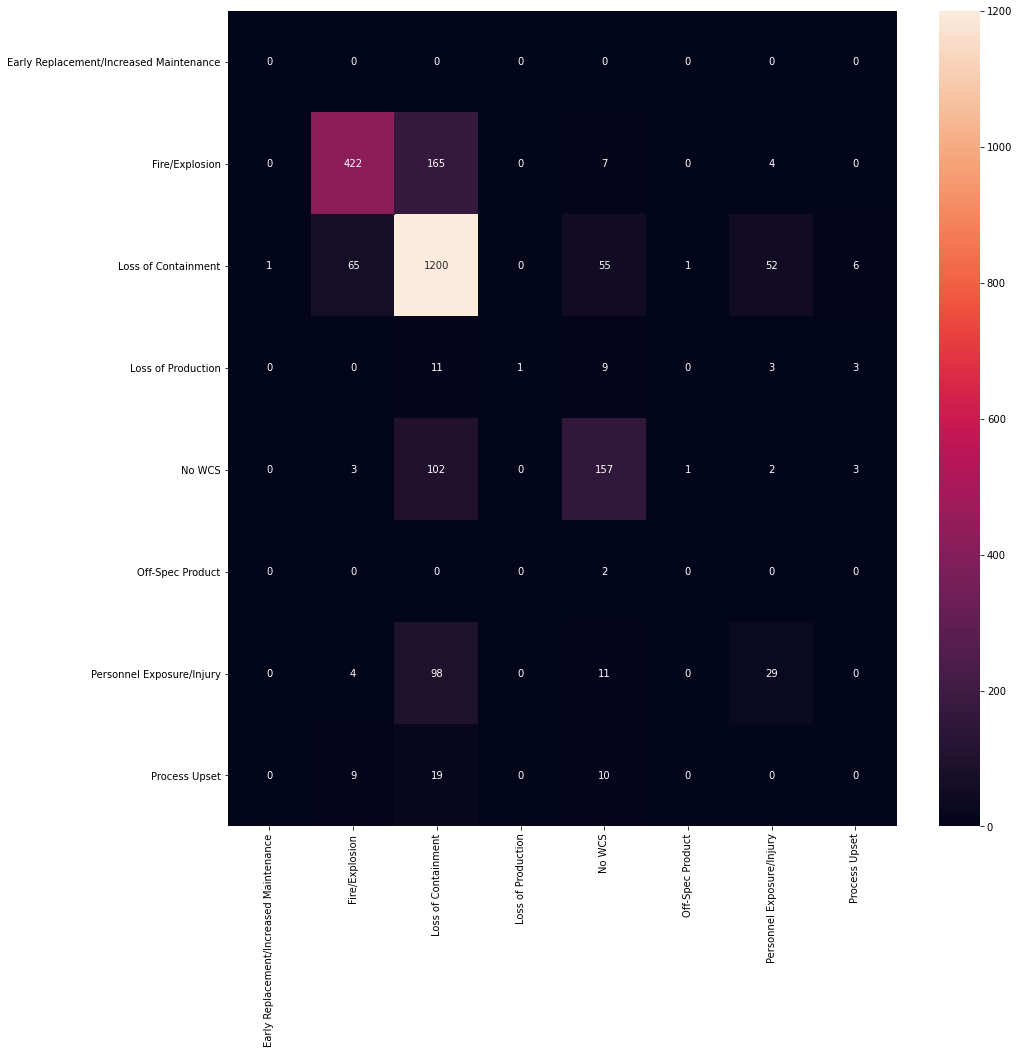

In [787]:
labels_WCS = unique_labels(df_result['wcs1'],df_result['WCS_pred'])
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(confusion_matrix(df_result['wcs1'],df_result['WCS_pred']), annot= True,fmt='g', ax = ax,xticklabels=labels_WCS, yticklabels=labels_WCS)

/tmp/ipykernel_5591/1141098267.py:3: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<AxesSubplot:>

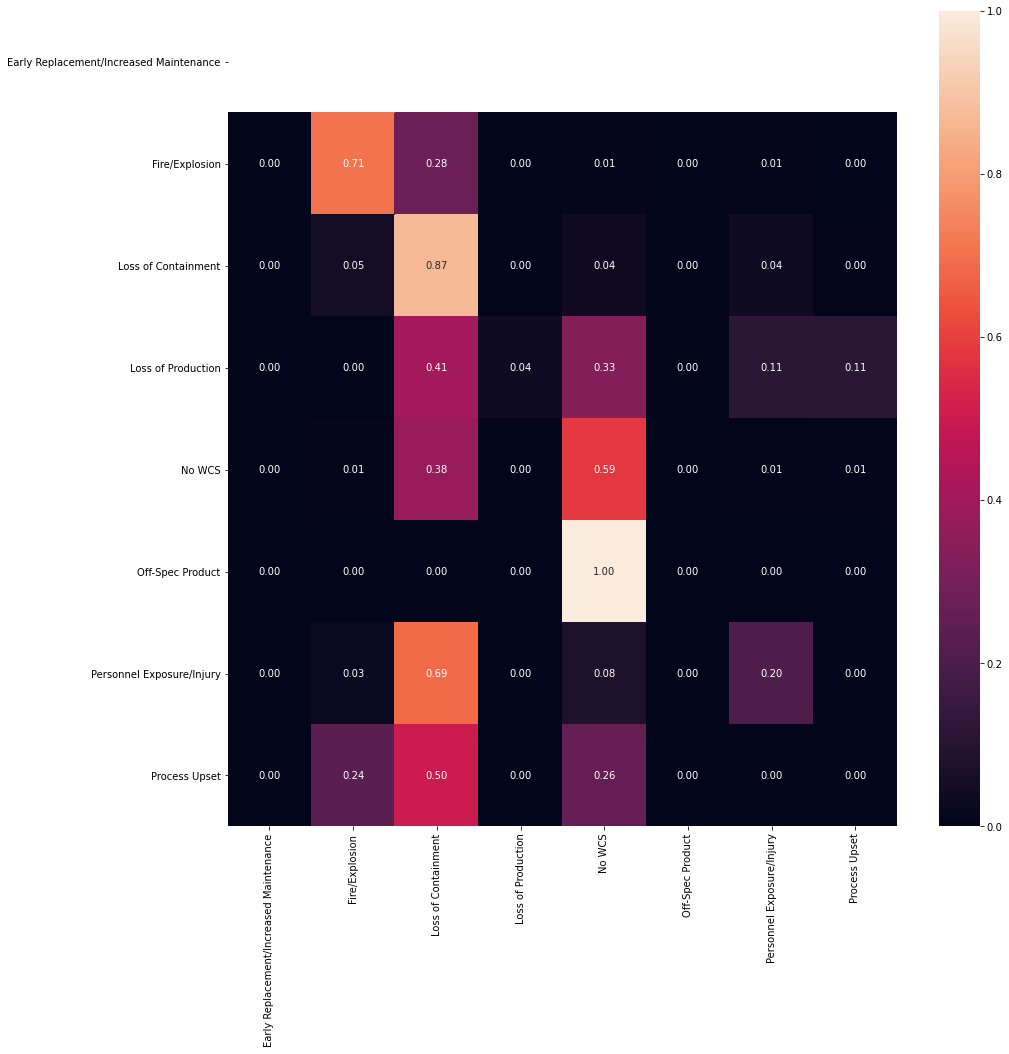

In [788]:
fig, ax = plt.subplots(figsize=(15,15)) 
cm = confusion_matrix(df_result['wcs1'],df_result['WCS_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot= True,fmt='.2f', ax = ax,xticklabels=labels_WCS, yticklabels=labels_WCS)

# Investigate data

In [789]:
def get_most_confused(results,true_col = 'UnwantEvent_wo_Receptor',pred_col = 'ue_prediction',max_rows = 3):
    """ 
    get the most confused columns in a multiclass classification results
    
    inputs:
    ------
    results: pd.DataFrame, including at lea
    st two columsn with the prediction and the results
    true_col: string, the name of the true column
    pred_col: string, the name of the predicted column
    max_rwos: top rows to show
    
    returns:
    -------
    most_confused_df: pd.DataFrame with the most confused columns and the counts  
    """
    
    cm = confusion_matrix(results[true_col], results[pred_col])
    # Browse the confusion matrix to count the class confusions
    most_confused_dict = {}
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                most_confused_dict[(i, j)] = cm[i, j]

    # Transform the dict into a np.ndarray
    most_confused = np.append(np.array(list(most_confused_dict.keys())),
                              np.array(list(most_confused_dict.values())).reshape(-1, 1),
                              axis=1)
    
        # Transform the dict into a np.ndarray
    most_confused = np.append(np.array(list(most_confused_dict.keys())),
                              np.array(list(most_confused_dict.values())).reshape(-1, 1),
                              axis=1)
    # Sort the array by the third column containing the counts
    most_confused.view('i8,i8,i8').sort(order=['f2'], axis=0)
    # Reverse the sort order
    most_confused = most_confused[::-1, :]
    # Keep only max_rows rows
    
    if max_rows is not None:
        most_confused = most_confused[:max_rows, :]

    most_confused_df = pd.DataFrame(most_confused, columns = ['true_label','pred_label','Count'])
    
    labels = sorted(set(list(results[true_col].unique())+list(results[pred_col].unique())))
                                            
    mapping = dict(zip([i for i in range(len(labels))],labels))
    #mapping[9]='NA'
    most_confused_df['true_label'] = most_confused_df['true_label'].apply(lambda x:mapping[x])
    most_confused_df['pred_label'] = most_confused_df['pred_label'].apply(lambda x:mapping[x])
    
    return most_confused_df

In [790]:
get_most_confused(df_result,'UnwantEvent_wo_Receptor',"UE_pred",max_rows=10)

,true_label,pred_label,Count
0,Upset,Damage,104
1,Increased Emissions,Damage,57
2,Explosive Mixture,Damage,31
3,Upset,Increased Emissions,28
4,Maintenance/Sampling/Operator Error,Damage,25
5,Flame Instability,Damage,22
6,Damage,Upset,18
7,Damage,Increased Emissions,18
8,Release,Damage,13
9,Increased Emissions,Upset,13


In [791]:
get_most_confused(df_result,'wcs1',"WCS_pred",max_rows=10)

,true_label,pred_label,Count
0,Fire/Explosion,Loss of Containment,165
1,No WCS,Loss of Containment,102
2,Personnel Exposure/Injury,Loss of Containment,98
3,Loss of Containment,Fire/Explosion,65
4,Loss of Containment,No WCS,55
5,Loss of Containment,Personnel Exposure/Injury,52
6,Process Upset,Loss of Containment,19
7,Personnel Exposure/Injury,No WCS,11
8,Loss of Production,Loss of Containment,11
9,Process Upset,No WCS,10


In [792]:
pd.set_option('display.max_colwidth', 0)

In [793]:
df_result = df_result[["ProjectId","Project Name","Company Name",'cause_conseq',"UnwantEvent_wo_Receptor","wcs1","UE_pred","WCS_pred"]]

In [794]:
df_result[df_result['UnwantEvent_wo_Receptor'] != df_result['UE_pred']][['cause_conseq',"UnwantEvent_wo_Receptor","UE_pred"]]

,cause_conseq,UnwantEvent_wo_Receptor,UE_pred
17082,"Operator fails to confirm that the nitrogen line block valve and the HF acid line block valve at the truck are closed because they were distracted, assume Vendor has them blockedTruck Valves are not blocked, Potential HF leak from truck hoses while truck is below 25 psig, possible personnel exposure",Maintenance/Sampling/Operator Error,Damage
17084,"43PCV414 on fuel gas supply to Depropanizer Reboiler H-21 malfunctions openIncreased flow of fuel gas to main burners at Depropanizer Reboiler H-21, potential high fuel gas pressure leading to overfiring in heater, potential process upset in Depropanizer W-4301, potential flame lift-off, potential flameout leading to accumulation of unburned fuel in firebox, potential firebox explosion, potential impact to personnel health and safety\n\n[LOPA Scenario: 12.7.1.1]\n\n[Initiating Cause Likelihood: 0.1][BPCS instrument loop failure]\n\n[Enabling Event: N/A][Probability: 1]\n\n[Conditional Modifier: N/A][Probability: 1]",Explosive Mixture,Damage
17085,"Tube leak/rupture of any of the 2 1/2"" tubes in the HP Sulfur Boiler (41-C823).Potential rise in pressure in the Reactor Furnace (36-C823). Will not exceed the MAWP of the HP Sulfur Boiler Shell (41-C823). Not likely to lose containment but may shut down the furnace on high pressure which would result in a lack of H2S conversion convertor/claus reactor section leading to higher emmissions at the stack. Emissions exceeding permit levels. Dispersion modeling showed that ERPG2 would not be exceeded below 50'. Potential environemental concern. [Revalidated]",Increased Emissions,Damage
17087,"Dumping spent Alumina from D3635/6 which will contain residual Butane.Potential for localised flammable atmosphere to develop and for ignition to occur due to static discharge resulting in localised flash fire or explosion, worst consequence expected to be limited to multiple lost time injuries.",Explosive Mixture,Damage
17093,"3"" manual valve (D16) is misaligned closed?Stop or lose ability to transfer from 30-A-002 Sewer Neutralization Sump to 30-95-302 Spent Caustic Mixing Tank. Increase level in 30-A-002 Sewer Neutralization Sump. Potential to overfill 30-A-002 Sewer Neutralization Sump. Potential personnel exposure.",Release,Upset
...,...,...,...
19482,"Dumping of spent caustic from W3635 to regeneration pits.Potential to lose level from W3635 if dump valve is left open for too long, flare gases released to atmosphere via regeneration pit, localised flammable and toxic hazard, possible flash fire or toxic exposure, worst case single lost time injury.",Damage,Upset
19483,"Overfill/spill of the lubrimist oil.LOC of lubrimist, environmental exceedance and personnel exposure. [Revalidated]",Release,Damage
19510,"Control valve (TV054 on MF_26) malfunctions open, or bypass valve is misaligned open.High burner header pressure leading to flame instability, potential for a fuel rich firebox with the potential for afterburn and/or firebox explosion. Potential failure of the firebox. [Revalidated]",Flame Instability,Explosive Mixture
19517,"Steam flow increased to caustic heater X3656.Circulating caustic temperature will increase and water will begin to be boiled-out of the solution if the temperature reaches the boiling point. The design temperature of 250F is not expected to be exceeded significantly, but the strength of the caustic will increase and plugging may become more likely resulting in reduced circulation rate. This has no additional hazardous consequences, but the increased temperature will increase the risk of caustic cracking with potential for this to lead to premature failure with initially minor leak expected. Possible loss of containment of caustic leading to worst case single lost time injury.",Upset,Damage


In [795]:
df_result[df_result['wcs1'] != df_result['WCS_pred']][["cause_conseq","wcs1","WCS_pred"]]

,cause_conseq,wcs1,WCS_pred
17070,"43FCV571 at Alkylate Fractionator W-82 inlet malfunctions closed or Manual valve closed on fractionator inletLoss of feed to Alkylate Fractionator W-82, potential deadhead of Alkylate Fractionator Bottoms Pump P-555 or P-571 as level control attempts to maintain level in tower, potential damage to pump and/or pump seal, potential seal leak, potential loss of containment of heavy alkylate with trace amounts of HF acid/fluorides, potential personnel exposure, potential fire, potential impact to personnel health and safety",Fire/Explosion,Loss of Containment
17071,"Loss of cooling water supply to First Stage Alkylation Reactor X-4304Loss of cooling at First Stage Alkylation Reactor X-4304 leading to increased ASO-make and potential for increased acid consumption, increased potential for acid runaway, if runaway conditions are not mitigated the potential for development of pin-hole leaks of LPG in equipment downstream of Defluorinators/KOH Treaters may occur over time, potential personnel exposure, potential fire or explosion, potential impact to personnel health and safety",Loss of Containment,Fire/Explosion
17074,"Operator fails to open the block valves on the nitrogen line up to the truck because they are distracted or busy with Unit upsetPotential inaccurate leak test, possible flange leak, potential LOC of HF, personnel exposure",Loss of Containment,Personnel Exposure/Injury
17077,"43HV423 at Isobutane side draw Depropanizer W-4301 closed or Manual valve misalignment - valve closed on line-up to First Stage Alkylation Reactor X-4304Loss of recycle isobutane to First Stage Alkylation Reactor X-4304 leading to low I/O ratio at reactor, potential acid runaway condition, potential development of corrosion-caused pin-hole leaks of LPG in equipment downstream of treaters, potential loss of containment, potential personnel exposure, potential fire, potential impact to personnel health and safety",Loss of Containment,Fire/Explosion
17079,"CAF # - 20170043204806046 - Add low point drain on D-718 Debutanizer reflux drum http://livelink.phillips66.net/livelink.exe?func=work.StatusHeader&workid=204806046&subworkid=204806046Potential to collect residual water from Start-up or reboiler tube failure, potential corrosion of 3/4"" OD low point drain of D-718, possible LOC of Butane, possible vapor cloud D-718 operates at ~85 psig LOPA is not applicable",Loss of Containment,Fire/Explosion
...,...,...,...
19497,"Misaligned valve on suction to P-1060 / P-1066, Misaligned valve to P-1060 / P-1066 suction from D-488, Misaligned valve in N2 line closedPotential to get caustic to the OWS via the oxygen analyzer AI-43500. LOC of caustic",Loss of Containment,Early Replacement/Increased Maintenance
19501,"Rerun column feed pump 17G-5 manual discharge valves are closed (most likely during HF acid charge to acid settler 17C-6B, when manual valves are operated to maintain flow)Potential acid rerun column feed pump 17G-5 deadhead and damage (shaft dia.=2"", hole size= 1/4"", pressure=242 psig), loss of containment of HF acid and light hydrocarbons (isobutane seal flush), resulting in toxic exposure (HF acid), fire hazards, and environmental impacts\n\n[LOPA Scenario: 8.2]\n\n[Initiating Cause Likelihood: 0.1][Human Error - (Routine Task - assumes well trained, unstressed, not fatigued, Once per Day Opportunity) 1x10-1 ]",Fire/Explosion,Loss of Containment
19505,"Inadvertently open Flare Line valve with the Rerun valve open; both valves are on the Acid Cooler Header. V14/X10 on MF_23Flow from the Rerun Pump, 67-R024/26 suction could enter the Acid Relief Line which can lower the acid level in the Reactor Settler, 95-RA24. Low level in the Settler will cause acid circulation to stop. Catalytic reaction would still occur in the Settler but there would be no cooling. Loss of acid to the acid relief header. Temperature and pressure would build in the Settler. Possible overpressure of Settler possible gasket failure and release

# Grouping Metrics

In [796]:
from sklearn.metrics import fowlkes_mallows_score

In [797]:
df = df[df['Center'].notna()]
df = df[df['Center'].str.split(" - ").apply(len) == 3]

In [798]:
df["Equipment"]=df['Center'].str.split(" - ").apply(lambda x: x[0])

In [799]:
df['BTC_true_noEquip'] = df['UnwantEvent_wo_Receptor'] + " - " + df['wcs1']
df['BTC_pred_noEquip'] = df['UE_pred'] + " - " + df['WCS_pred']
df['BTC_true'] = df['Equipment'] +" - " + df['UnwantEvent_wo_Receptor'] + " - " + df['wcs1']
df['BTC_pred'] = df['Equipment'] +" - " + df['UE_pred'] + " - " + df['WCS_pred']

In [800]:
fowlkes_mallows_score(df['BTC_true_noEquip'],df['BTC_pred_noEquip'])

0.6753898375205767

In [802]:
fowlkes_mallows_score(df['BTC_true'],df['BTC_pred'])

0.8816759146255845